# EDA Human Protein




# Train DataSet

Датасет состоит из 31.072 изображений (сэмплов), каждому соответсвуют 4 канала-фильтра: red, green, blue и yellow. На изображениях присутсвуют метки месторасположения различных структур (органелл) белка. Всего в наборе данных присутсвуют 28 классов органелл белка, которые необходимо предсказать.


### 1. Частотность лейблов в train 

Рассмотрим частостность встречаемости лейблов в наборе ланных 

<img src="newplot.png">

* Исходя из графика, предсавленного выше, можно сделать вывод, что чаще всего встречаются Nucleoplasm, Cytosol и Plasma membrane. Скорее всего, будущая модель научится хорошо предсказывать данные классы, потому что они хорошо представленны в выборке.

* Такие лейблы как Peroxisomes, Endosomes, Lysosomes and etc. очень редко встречаются в трейне ( меньше 100 примеров). Предсказывать такие классы будет очень сложно. При обученнии необходимо будет обратить особое внимание к данным классам. Например, при обучении ввести class_weights, или насэмплить еще примеров с данными классами.



### 2. Количество классов на изображении

В большинстве сэмплах присутсвует либо один класс, либо представленно два класса. Очень редко встречаются больше чем три класса на изображении.  

<img src="newplot_1.png">










### 3. Связь между лейблами 

* Большинство классов не имеют корреляции 

<img src="correlation.png">

*  Классы Endosomes и Lysosomes встречаются вместе очень часто. Также вместе с ними иногда присутсвует Endoplasmic reticulum.

Это можно объяснить тем, что при образовании лизосом учавствуют эндосомы (пузырьки), вблизи ( на поверхности) мембран эндоплазматического ретикулума

* У классов Cytokinetic bridge и Mitotic spindle; Cytokinetic bridge и Microtubles наблюдается небольшая положительная корреляция.




<img src="correlation-1.png">



### 4. Примеры изображений 
Одному сэмплу соответсвуют четыре канала. ВОзьмем в качестве примера один сэмпл, на котором представленны четыре класса:  1, 9, 2, 0 
1.  Nuclear membrane 
9.  Endosomes 
2.  Nucleoli
0.  Nucleoplasm  
  
<img src="image-4.png">



Объединим все четыре канала в один четырехканальный

<img src="image-1.png">


### Вывод

Мультиклассовая задача с мультилейблами, то в качестве выходного уровня нужно использовать не SoftMax

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import pickle

import tensorflow as tf
sns.set()

import os



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
train_labels = pd.read_csv("../../ceph-data/kaggle-protein/train.csv")
train_labels.head()



,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
train_labels.shape

(31072, 2)

In [5]:
pickle_in = open("dict_labels.pickle","rb")
label_names = pickle.load(pickle_in)

In [6]:
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [7]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0
    

In [8]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head(2)

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
count_labels = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)


In [10]:
df_labels = pd.DataFrame(count_labels).reset_index()
df_labels.rename(columns={"index":"Name", 0:"counts"}, inplace=True)

### 1. Частотность лейблов в трейне 

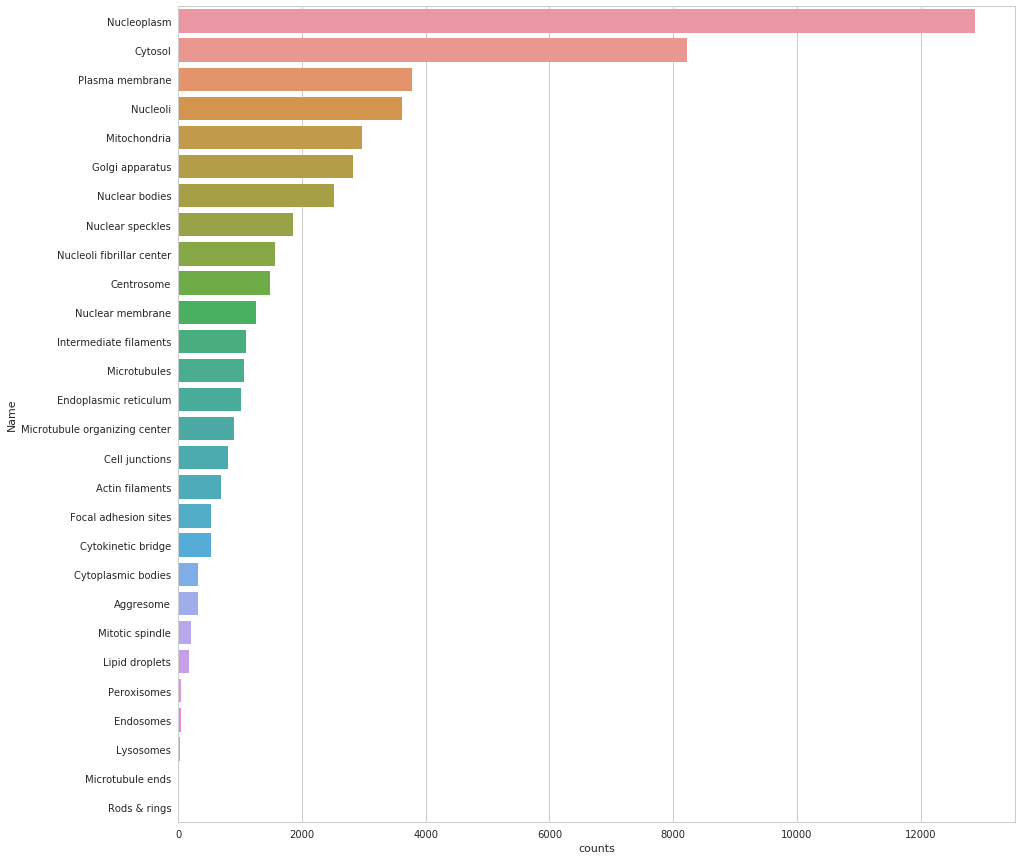

In [15]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(15,15))
ax = sns.barplot(x="counts", y="Name", data=df_labels)

### 2. Сколько лейблов встречаются на изображении 

In [93]:
train_labels['all_target']= train_labels.Target.apply(lambda x: len(x))
label_value = train_labels[['Id', 'all_target']].groupby('all_target').count()

In [99]:
label_value.reset_index(inplace=True)

### 3. Корреляция между классами 

In [148]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)

In [149]:
z=train_labels[train_labels.number_of_targets>1].drop(["Id", "Target", "number_of_targets"],axis=1).corr()

In [11]:
def heatmap(C):
    mask = np.zeros_like(C)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    hm = sns.heatmap(C,
                mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                vmax=.3,
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5})
    hm.set_facecolor('w')
    return hm


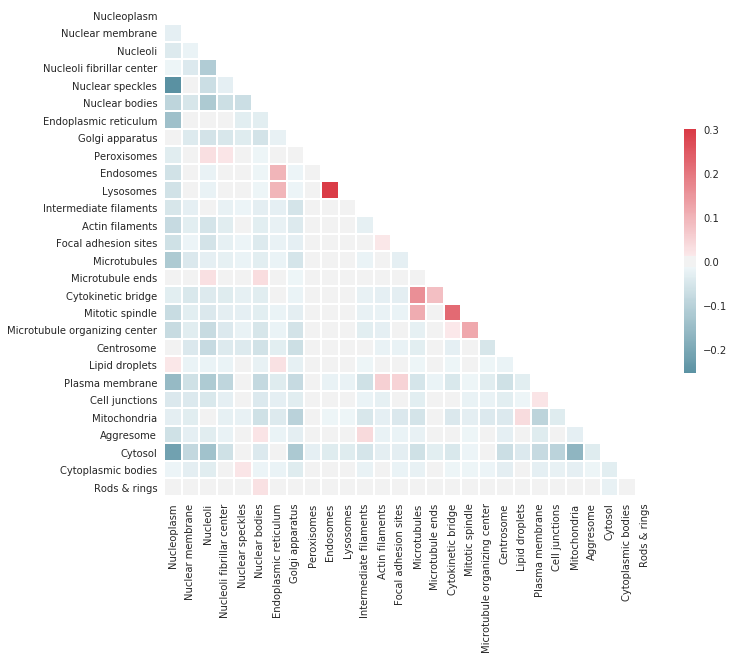

In [13]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
C = train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr()
heatmap(C)



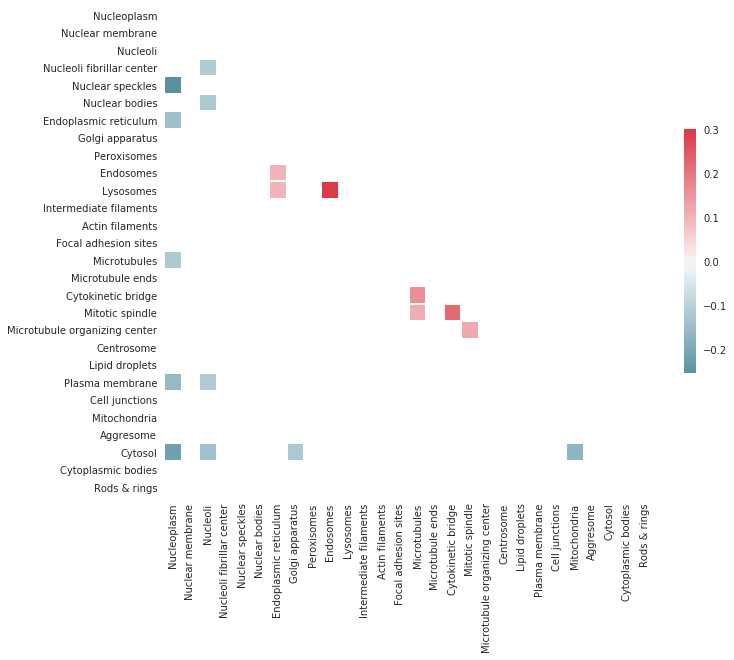

In [15]:
heatmap(C[abs(C)> 0.1])

# 4. Load img

In [32]:
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [33]:
train_labels.query('Id == "039085dc-bbaa-11e8-b2ba-ac1f6b6435d0"')

,Id,Target
393,039085dc-bbaa-11e8-b2ba-ac1f6b6435d0,19 2 0


In [20]:
img_1 = '039085dc-bbaa-11e8-b2ba-ac1f6b6435d0'

In [21]:
images = []
images.append(plt.imread('../../ceph-data/kaggle-protein/train/' +img_1 + '_red.png'))
images.append(plt.imread('../../ceph-data/kaggle-protein/train/' +img_1 + '_green.png'))
images.append(plt.imread('../../ceph-data/kaggle-protein/train/' +img_1 + '_blue.png'))
images.append(plt.imread('../../ceph-data/kaggle-protein/train/' +img_1 + '_yellow.png'))


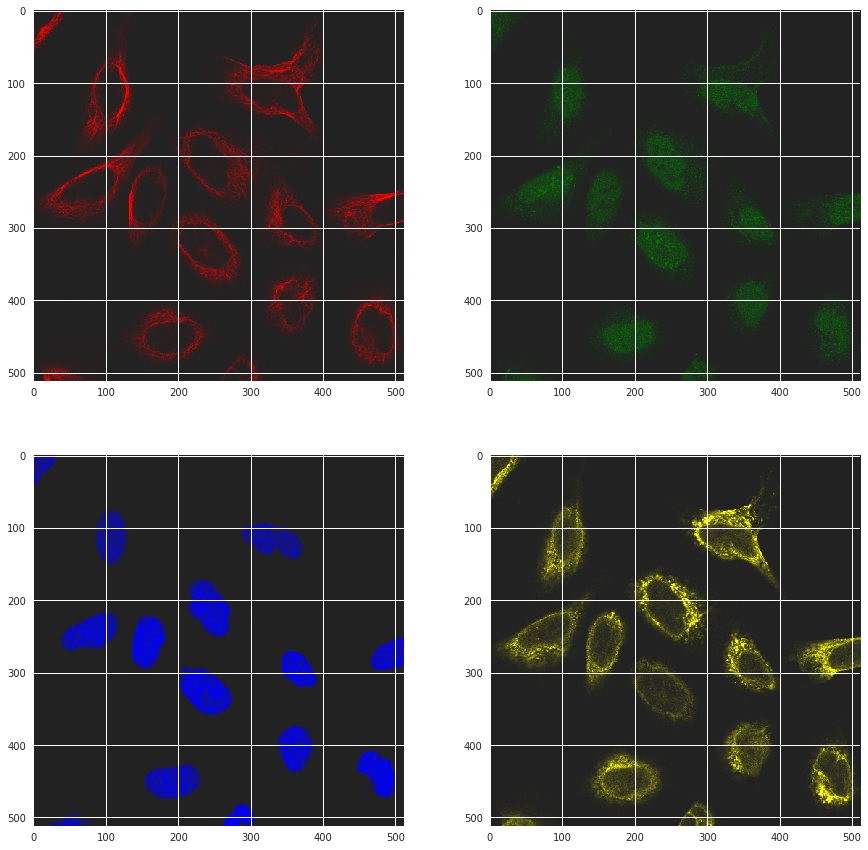

In [24]:
plt.figure(figsize=(15,15))
cmaps = [sns.dark_palette("red", as_cmap=True),
         sns.dark_palette("green", as_cmap=True),
         sns.dark_palette("blue", as_cmap=True),
         sns.dark_palette("yellow", as_cmap=True)]
for img in range(4):
    plt.subplot(2,2,img+1)
    plt.imshow(images[img], cmap=cmaps[img])

In [25]:
def to_rgba2(img):
    r = np.transpose(np.vectorize(lambda x: (1,0,0,x))(img[0]))
    g = np.transpose(np.vectorize(lambda x: (0,1,0,x))(img[1]))
    b = np.transpose(np.vectorize(lambda x: (0,0,1,x))(img[2]))
    y = np.transpose(np.vectorize(lambda x: (1,1,0,x))(img[3]))
    return np.array([r,g,b,y])

In [26]:
%time r = to_rgba2(images)

CPU times: user 340 ms, sys: 32 ms, total: 372 ms
Wall time: 371 ms


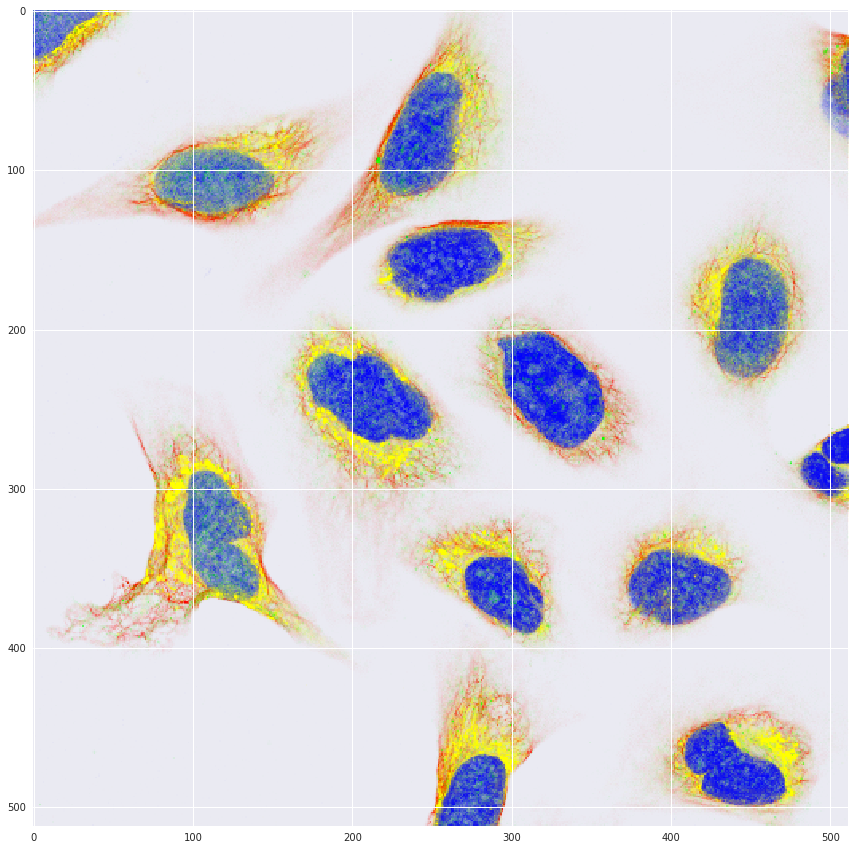

In [27]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.imshow(r[i])